<a href="https://colab.research.google.com/github/kunalrajsingh/Audio-Classification-using-LSTM-GRU/blob/main/audio_data_classification_using_lstm_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import librosa
import os
import numpy as np
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/UrbanSound8K.csv')

metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(metadata["class"].value_counts())
class_names = [ 'dog_bark',
        'children_playing',
        'air_conditioner',
        'street_music',
        'jackhammer',
        'engine_idling',
        'drilling',
        'siren',
        'car_horn',
        'gun_shot']

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio
audio_file_path = "/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/fold5/100032-3-0-0.wav"
audio_data, sample_rate = librosa.load(audio_file_path, sr=None)

Audio(audio_file_path)

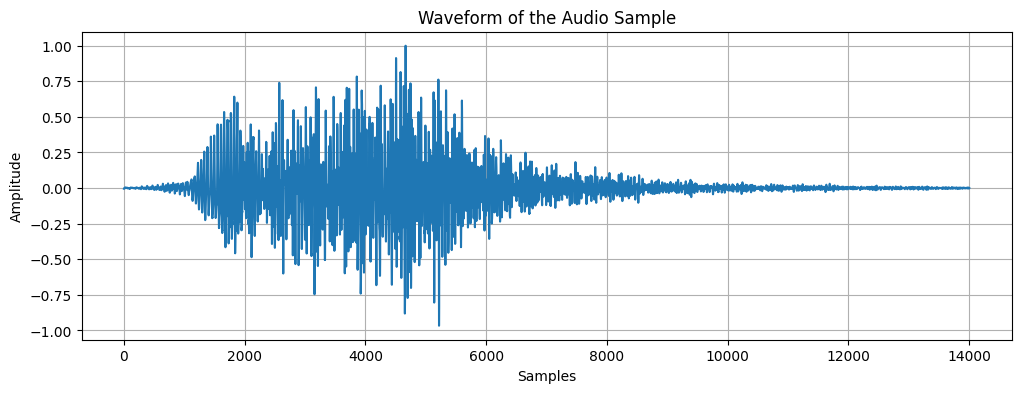

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title('Waveform of the Audio Sample')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(file_path, sample_rate):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

def load_audio_files(dataframe, sample_rate=22050, duration=5):
    audio_data = []
    labels = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for index, row in dataframe.iterrows():
            # Modified: Check if file exists before processing
            file_path = os.path.join('/content/drive/MyDrive/UrbanSound8K/UrbanSound8K', 'fold' + str(row['fold']), row['slice_file_name'])
            if os.path.exists(file_path):  # Check if the file exists
                futures.append(executor.submit(process_audio_file, file_path, sample_rate))
                labels.append(row['classID'])
            else:
                print(f"Warning: File not found: {file_path}")  # Print a warning for missing files

        for future in futures:
            audio_data.append(future.result())

    return np.array(audio_data), np.array(labels)


X, y = load_audio_files(metadata)
print(X.shape, y.shape)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


(7293, 13) (7293,)


In [ ]:
print(y[1])#labels
print(X[1])#Audio Data

2
[-417.0052      99.336624   -42.995583    51.073326     9.853777
    7.969693    11.197088     1.9291173    7.0303974    4.270228
   -3.5847254   13.890946    -2.764493 ]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (X_train.shape[1], X_train.shape[2])
model = models.Sequential([
    layers.GRU(64, input_shape=input_shape, return_sequences=True),
    layers.GRU(32),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')

])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2453 - loss: 2.1221 - val_accuracy: 0.4353 - val_loss: 1.6397
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4975 - loss: 1.4932 - val_accuracy: 0.5347 - val_loss: 1.3878
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5910 - loss: 1.2756 - val_accuracy: 0.5484 - val_loss: 1.3111
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6204 - loss: 1.1429 - val_accuracy: 0.5750 - val_loss: 1.2597
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6570 - loss: 1.0380 - val_accuracy: 0.5938 - val_loss: 1.1962
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6836 - loss: 0.9800 - val_accuracy: 0.6307 - val_loss: 1.1487
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7005 - loss: 0.9304 - val_accuracy: 0.6315 - val_loss: 1.1172
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7149 - loss: 0.8752 - val_accuracy: 0.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6755 - loss: 1.0037
Test Accuracy: 0.7004798054695129


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = y_test
report = classification_report(actual_classes, predicted_classes, target_names= [ 'dog_bark',
        'children_playing',
        'air_conditioner',
        'street_music',
        'jackhammer',
        'engine_idling',
        'drilling',
        'siren',
        'car_horn',
        'gun_shot'])

print(report)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                  precision    recall  f1-score   support

        dog_bark       0.76      0.81      0.78       171
children_playing       0.76      0.56      0.65        94
 air_conditioner       0.55      0.51      0.53       175
    street_music       0.73      0.61      0.67       185
      jackhammer       0.84      0.71      0.77       174
   engine_idling       0.86      0.77      0.81       149
        drilling       0.57      0.76      0.65        72
           siren       0.82      0.90      0.86       125
        car_horn       0.85      0.75      0.80       138
        gun_shot       0.47      0.68      0.55       176

        accuracy                           0.70      1459
       macro avg       0.72      0.71      0.71      1459
    weighted avg       0.72      0.70      0.70      1459



In [ ]:
predictions = model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

actual_classes = y_test

for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {actual_classes[i]}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted: 2, Actual: 2
Predicted: 6, Actual: 8
Predicted: 4, Actual: 1
Predicted: 3, Actual: 3
Predicted: 5, Actual: 9
Predicted: 9, Actual: 9
Predicted: 9, Actual: 3
Predicted: 9, Actual: 8
Predicted: 3, Actual: 3
Predicted: 5, Actual: 5


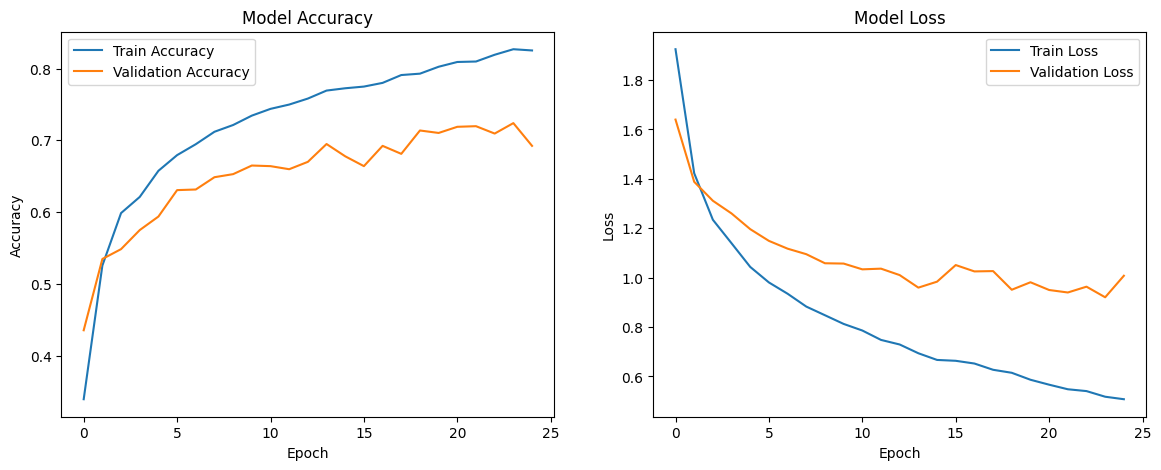

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

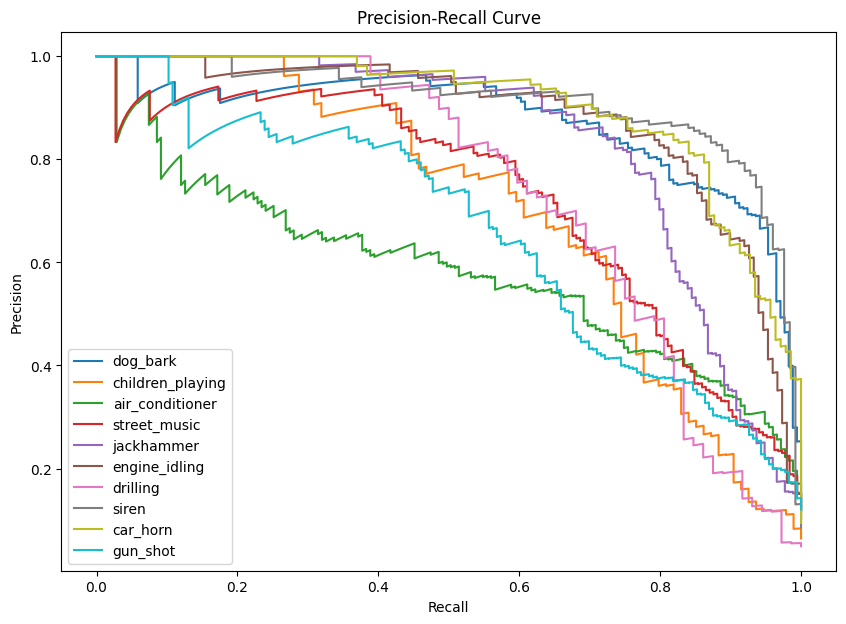

In [ ]:
from sklearn.metrics import precision_recall_curve

precision = {}
recall = {}
thresholds = {}

for i, class_name in enumerate(class_names):
    precision[i], recall[i], thresholds[i] = precision_recall_curve((actual_classes == i).astype(int), predictions[:, i])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=class_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

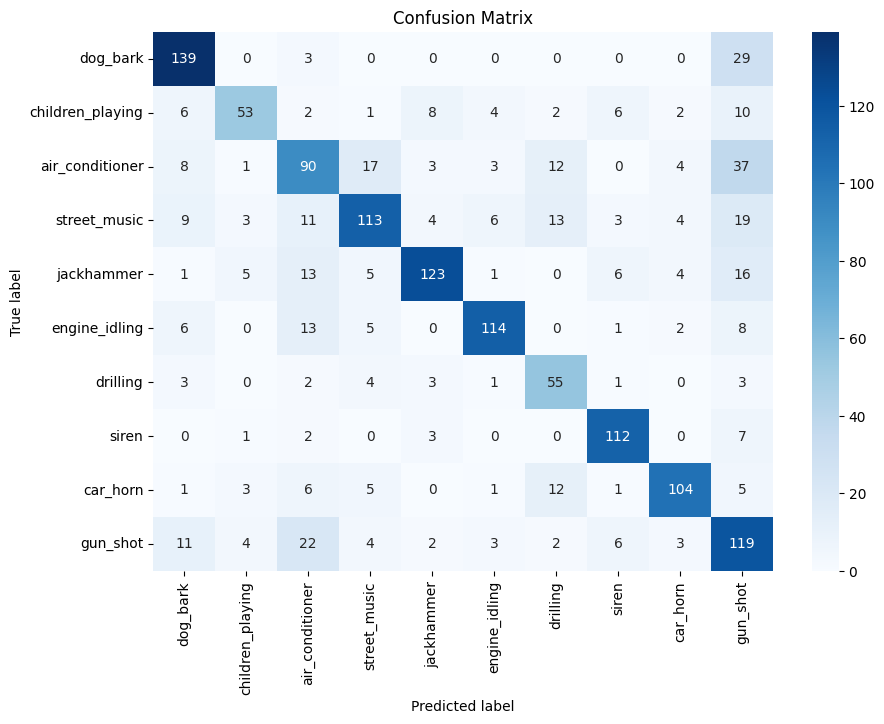

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_labels = y_test


cm = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names),
            yticklabels=list(class_names ))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

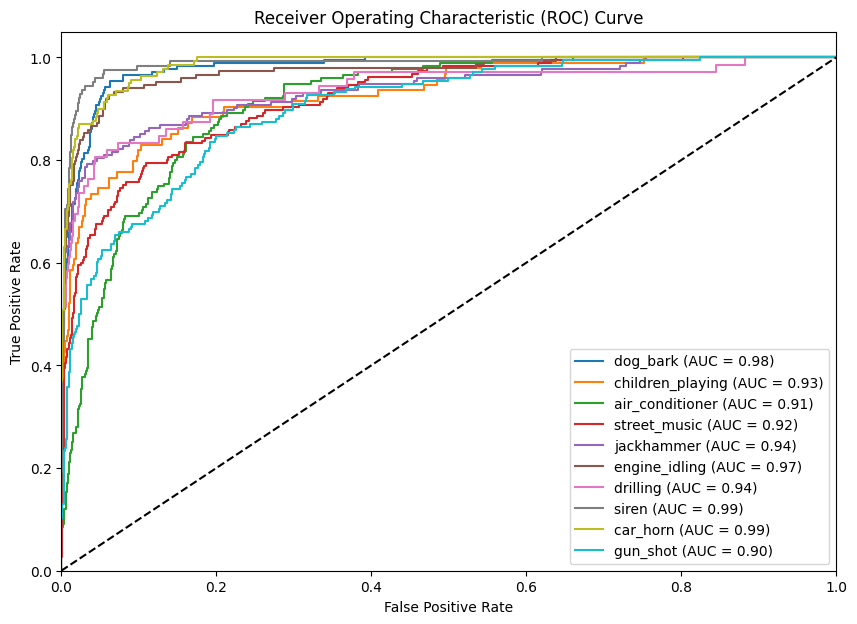

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve((actual_classes == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 64)               │          15,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,896 (425.38 KB)

 Trainable params: 36,298 (141.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,598 (283.59 KB)

In [ ]:
!pip install librosa matplotlib

<ipython-input-31-6799dbaa3862>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/fold1/176787-5-0-24.wav'

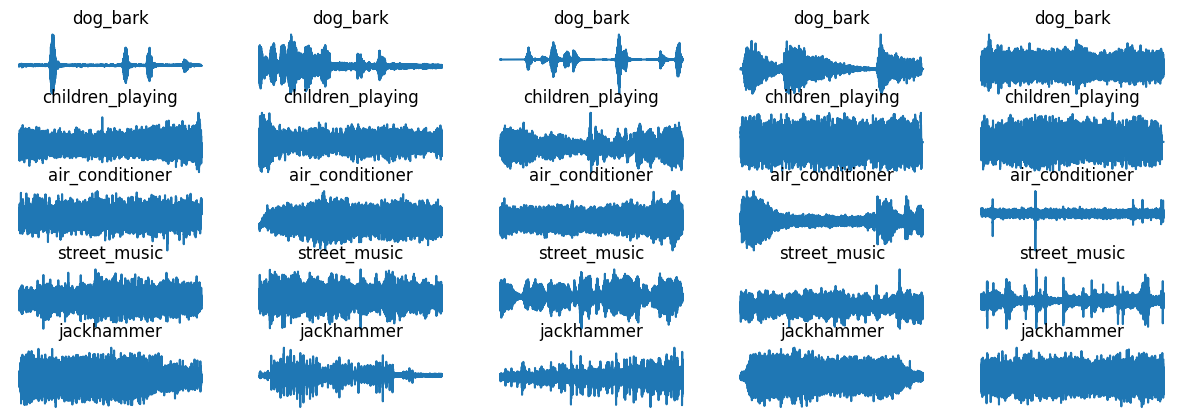

In [ ]:
import matplotlib.pyplot as plt
import librosa
import random

# Select a few random audio files from different classes
num_samples = 5  # Number of samples per class
class_samples = {}
for class_name in class_names:
    class_samples[class_name] = random.sample(metadata[metadata['class'] == class_name]['slice_file_name'].tolist(), num_samples)

# Plot waveforms
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    for j, file_name in enumerate(class_samples[class_name]):
        file_path = os.path.join('/content/drive/MyDrive/UrbanSound8K/UrbanSound8K', 'fold' + str(metadata[metadata['slice_file_name'] == file_name]['fold'].values[0]), file_name)
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
        plt.plot(audio_data)
        plt.title(class_name)
        plt.axis('off')  # Turn off axis labels for cleaner visualization

plt.tight_layout()
plt.show()